In [2]:
import sys
import os

current_directory = os.getcwd()        
parent_directory = os.path.dirname(current_directory)
sys.path.append(parent_directory)


from preprocess.graph import graph_topology_5
from preprocess.BaselinePrerocess import baseline_process, baseline_process_for_gate_predictor
from preprocess.GraphTransformerPrerocess import graph_water_transformer_cov_process_for_gate_predictor
from baselines.mlp import mlp_gate_generator_1
from models.graph_water_transformer_cov import graph_water_transformer_cov_gate_predictor

from losses.loss import gate_loss, water_level_threshold
from tensorflow.keras.models import load_model
from tensorflow import keras
from tensorflow.keras import Input, Model
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
import time
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from postprocess.threshold import flood_threshold, drought_threshold, flood_threshold_t1, drought_threshold_t1
from spektral.layers import GCNConv

In [3]:
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [4]:
n_hours = 72
K = 24 
masked_value = 1e-10
split_1 = 0.8
split_2 = 0.9
sigma2 = 0.1
epsilon = 0.5

In [5]:
train_X_mask, val_X_mask, test_X_mask, \
train_ws_y, val_ws_y, test_ws_y, \
scaler, ws_scaler = baseline_process(n_hours, K, masked_value, split_1, split_2)

Index(['WS_S1', 'WS_S4', 'FLOW_S25A', 'GATE_S25A', 'HWS_S25A', 'TWS_S25A',
       'FLOW_S25B', 'GATE_S25B', 'GATE_S25B2', 'HWS_S25B', 'TWS_S25B',
       'PUMP_S25B', 'FLOW_S26', 'GATE_S26_1', 'GATE_S26_2', 'HWS_S26',
       'TWS_S26', 'PUMP_S26', 'MEAN_RAIN'],
      dtype='object')


In [6]:
train_cov, val_cov, test_cov, \
train_tws_reshape, val_tws_reshape, test_tws_reshape, \
train_gate_pump_y, val_gate_pump_y, test_gate_pump_y, \
train_ws_y, val_ws_y, test_ws_y, \
scaler, ws_scaler, gate_scalar = graph_water_transformer_cov_process_for_gate_predictor(n_hours, K, masked_value, split_1, split_2)

Index(['WS_S1', 'WS_S4', 'FLOW_S25A', 'GATE_S25A', 'HWS_S25A', 'TWS_S25A',
       'FLOW_S25B', 'GATE_S25B', 'GATE_S25B2', 'HWS_S25B', 'TWS_S25B',
       'PUMP_S25B', 'FLOW_S26', 'GATE_S26_1', 'GATE_S26_2', 'HWS_S26',
       'TWS_S26', 'PUMP_S26', 'MEAN_RAIN'],
      dtype='object')
train_tws/val_tws/test_tws: (77069, 5, 72) (9634, 5, 72) (19268, 5, 72) 
 train_cov/val_cov/test_cov: (77069, 96, 12) (9634, 96, 12) (19268, 96, 12) 
 train_ws_y/val_ws_y/test_ws_y: (77069, 96) (9634, 96) (19268, 96) 
  train_gate_pump_y/val_gate_pump_y/test_gate_pump_y: (77069, 24, 7) (9634, 24, 7) (19268, 24, 7)


### Graph topology

In [7]:
train_adj_mat, val_adj_mat, test_adj_mat = graph_topology_5(n_hours, K, sigma2, epsilon, len(train_ws_y), len(val_ws_y), len(test_ws_y))

node_indices: [0 0 0 0 1 1 2 2 3 3 4 4] 
neighbor_indices: [1 2 3 4 0 2 0 1 0 4 0 3]
number of nodes: 5, number of edges: 12


### Model

#### Gate & pump predictor

In [8]:
# # ===== model parameters ======
# mlp_unit1 = 256
# mlp_unit2 = 128
# mlp_unit3 = 64
# dropout = 0.0
# l1_reg = 0
# l2_reg = 0
# gate_min = 0
# gate_max = 1

# learning_rate = 1e-3
# decay_steps = 10000
# decay_rate = 0.95
# PATIENCE = 100
# EPOCHS = 700
# BATCH = 512
# input_shape = train_X_mask.shape[1:]


# ===== model parameters ======
mlp_unit1 = 512
mlp_unit2 = 256
mlp_unit3 = 128
dropout = 0.0
l1_reg = 1e-5
l2_reg = 1e-5
gate_min = 0
gate_max = 1


learning_rate = 1e-3
decay_steps = 10000
decay_rate = 0.95
PATIENCE = 100
EPOCHS = 700
BATCH = 512
input_shape = train_X_mask.shape[1:]

In [9]:
gate_predictor = mlp_gate_generator_1(input_shape, mlp_unit1, mlp_unit2, mlp_unit3, l1_reg, l2_reg, dropout, masked_value, gate_min, gate_max)
gate_predictor._name = "gate_predictor"
gate_predictor.summary()

Model: "gate_predictor"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 96, 16)]          0         
                                                                 
 masking (Masking)           (None, 96, 16)            0         
                                                                 
 dense (Dense)               (None, 96, 512)           8704      
                                                                 
 max_pooling1d (MaxPooling1  (None, 48, 512)           0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 48, 512)           0         
                                                                 
 dense_1 (Dense)             (None, 48, 256)           131328    
                                                    

2023-08-12 17:27:45.412567: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10402 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1080 Ti, pci bus id: 0000:05:00.0, compute capability: 6.1


In [10]:
gate_predictor.compile(optimizer='adam', loss='mse')

#### water stage predictor

In [11]:
ws_predictor = load_model('../saved_models/WaLeF_gtn_p.h5', custom_objects={'GCNConv': GCNConv})

for layer in ws_predictor.layers:
    layer.trainable = False

ws_predictor._name = 'ws_predictor'    
# ws_predictor.summary()

#### Combine gate_predictor and trained ws_predictor

In [12]:
inputs_feat = Input(shape=(96, 16), name='inputs_feat')
inputs_tws = Input(shape=(5, 72), name='input_tws')
inputs_adj = Input(shape=(5, 5), name='input_adj')

# ================ gate_predictor ================
gate_predictor_output = gate_predictor(inputs_feat)  # 24*7


# ============  future inputs with replaced gate & pump prediction ============
replaced_future_gate_pump = layers.Concatenate(axis=-1)([inputs_feat[:, n_hours:, :2], 
                                                         gate_predictor_output, 
                                                         inputs_feat[:, n_hours:, 9:]
                                                        ]
                                                       )

# ============ original past inputs + future inputs with replaced gate & pump prediction ============
merged_inputs = layers.Concatenate(axis=1)([inputs_feat[:, :n_hours, :], replaced_future_gate_pump])
merged_inputs_cov = merged_inputs[:, :, :12]

ws_predictor_output = ws_predictor([merged_inputs_cov, inputs_tws, inputs_adj])

filda = Model(inputs=[inputs_feat, inputs_tws, inputs_adj], outputs=[gate_predictor_output, ws_predictor_output], name='filda')
# filda.summary()

Epoch 1/700


2023-08-11 02:03:35.054219: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2023-08-11 02:03:36.327738: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fb1be7e3c60 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-08-11 02:03:36.327790: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce GTX 1080 Ti, Compute Capability 6.1
2023-08-11 02:03:36.336318: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-08-11 02:03:36.700484: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.



Epoch 1: val_ws_predictor_loss improved from inf to 3.38701, saving model to ../saved_models/mlp_gtnp_1.h5
151/151 - 18s - loss: 0.5614 - gate_predictor_loss: 0.0000e+00 - ws_predictor_loss: 0.2468 - val_loss: 6.8186 - val_gate_predictor_loss: 0.0000e+00 - val_ws_predictor_loss: 3.3870 - 18s/epoch - 119ms/step
Epoch 2/700


/aul/homes/jshi008/miniconda3/envs/tf213/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Epoch 2: val_ws_predictor_loss improved from 3.38701 to 2.84519, saving model to ../saved_models/mlp_gtnp_1.h5
151/151 - 8s - loss: 0.5159 - gate_predictor_loss: 0.0000e+00 - ws_predictor_loss: 0.2423 - val_loss: 5.7124 - val_gate_predictor_loss: 0.0000e+00 - val_ws_predictor_loss: 2.8452 - 8s/epoch - 55ms/step
Epoch 3/700

Epoch 3: val_ws_predictor_loss did not improve from 2.84519
151/151 - 8s - loss: 0.4965 - gate_predictor_loss: 0.0000e+00 - ws_predictor_loss: 0.2395 - val_loss: 6.3606 - val_gate_predictor_loss: 0.0000e+00 - val_ws_predictor_loss: 3.1734 - 8s/epoch - 55ms/step
Epoch 4/700

Epoch 4: val_ws_predictor_loss did not improve from 2.84519
151/151 - 8s - loss: 0.4886 - gate_predictor_loss: 0.0000e+00 - ws_predictor_loss: 0.2385 - val_loss: 5.9963 - val_gate_predictor_loss: 0.0000e+00 - val_ws_predictor_loss: 2.9933 - 8s/epoch - 55ms/step
Epoch 5/700

Epoch 5: val_ws_predictor_loss improved from 2.84519 to 2.82022, saving model to ../saved_models/mlp_gtnp_1.h5
151/151 - 8s

Epoch 31/700

Epoch 31: val_ws_predictor_loss did not improve from 2.30891
151/151 - 8s - loss: 0.4696 - gate_predictor_loss: 0.0000e+00 - ws_predictor_loss: 0.2330 - val_loss: 5.0868 - val_gate_predictor_loss: 0.0000e+00 - val_ws_predictor_loss: 2.5416 - 8s/epoch - 55ms/step
Epoch 32/700

Epoch 32: val_ws_predictor_loss did not improve from 2.30891
151/151 - 8s - loss: 0.4684 - gate_predictor_loss: 0.0000e+00 - ws_predictor_loss: 0.2324 - val_loss: 4.8836 - val_gate_predictor_loss: 0.0000e+00 - val_ws_predictor_loss: 2.4401 - 8s/epoch - 54ms/step
Epoch 33/700

Epoch 33: val_ws_predictor_loss did not improve from 2.30891
151/151 - 8s - loss: 0.4686 - gate_predictor_loss: 0.0000e+00 - ws_predictor_loss: 0.2326 - val_loss: 4.8764 - val_gate_predictor_loss: 0.0000e+00 - val_ws_predictor_loss: 2.4365 - 8s/epoch - 54ms/step
Epoch 34/700

Epoch 34: val_ws_predictor_loss did not improve from 2.30891
151/151 - 8s - loss: 0.4683 - gate_predictor_loss: 0.0000e+00 - ws_predictor_loss: 0.2324 - va

Epoch 61/700

Epoch 61: val_ws_predictor_loss did not improve from 2.30891
151/151 - 8s - loss: 0.4666 - gate_predictor_loss: 0.0000e+00 - ws_predictor_loss: 0.2316 - val_loss: 4.8196 - val_gate_predictor_loss: 0.0000e+00 - val_ws_predictor_loss: 2.4080 - 8s/epoch - 55ms/step
Epoch 62/700

Epoch 62: val_ws_predictor_loss did not improve from 2.30891
151/151 - 8s - loss: 0.4665 - gate_predictor_loss: 0.0000e+00 - ws_predictor_loss: 0.2315 - val_loss: 4.8016 - val_gate_predictor_loss: 0.0000e+00 - val_ws_predictor_loss: 2.3991 - 8s/epoch - 54ms/step
Epoch 63/700

Epoch 63: val_ws_predictor_loss did not improve from 2.30891
151/151 - 8s - loss: 0.4668 - gate_predictor_loss: 0.0000e+00 - ws_predictor_loss: 0.2317 - val_loss: 4.8869 - val_gate_predictor_loss: 0.0000e+00 - val_ws_predictor_loss: 2.4417 - 8s/epoch - 54ms/step
Epoch 64/700

Epoch 64: val_ws_predictor_loss did not improve from 2.30891
151/151 - 8s - loss: 0.4662 - gate_predictor_loss: 0.0000e+00 - ws_predictor_loss: 0.2314 - va

Epoch 91/700

Epoch 91: val_ws_predictor_loss did not improve from 2.29388
151/151 - 8s - loss: 0.4657 - gate_predictor_loss: 0.0000e+00 - ws_predictor_loss: 0.2312 - val_loss: 5.0452 - val_gate_predictor_loss: 0.0000e+00 - val_ws_predictor_loss: 2.5209 - 8s/epoch - 55ms/step
Epoch 92/700

Epoch 92: val_ws_predictor_loss did not improve from 2.29388
151/151 - 8s - loss: 0.4658 - gate_predictor_loss: 0.0000e+00 - ws_predictor_loss: 0.2312 - val_loss: 4.9286 - val_gate_predictor_loss: 0.0000e+00 - val_ws_predictor_loss: 2.4626 - 8s/epoch - 55ms/step
Epoch 93/700

Epoch 93: val_ws_predictor_loss did not improve from 2.29388
151/151 - 8s - loss: 0.4657 - gate_predictor_loss: 0.0000e+00 - ws_predictor_loss: 0.2312 - val_loss: 4.7691 - val_gate_predictor_loss: 0.0000e+00 - val_ws_predictor_loss: 2.3829 - 8s/epoch - 55ms/step
Epoch 94/700

Epoch 94: val_ws_predictor_loss did not improve from 2.29388
151/151 - 8s - loss: 0.4651 - gate_predictor_loss: 0.0000e+00 - ws_predictor_loss: 0.2310 - va

151/151 - 8s - loss: 0.4650 - gate_predictor_loss: 0.0000e+00 - ws_predictor_loss: 0.2309 - val_loss: 4.8922 - val_gate_predictor_loss: 0.0000e+00 - val_ws_predictor_loss: 2.4445 - 8s/epoch - 55ms/step
Epoch 121/700

Epoch 121: val_ws_predictor_loss did not improve from 2.29015
151/151 - 8s - loss: 0.4646 - gate_predictor_loss: 0.0000e+00 - ws_predictor_loss: 0.2308 - val_loss: 4.8712 - val_gate_predictor_loss: 0.0000e+00 - val_ws_predictor_loss: 2.4341 - 8s/epoch - 55ms/step
Epoch 122/700

Epoch 122: val_ws_predictor_loss did not improve from 2.29015
151/151 - 8s - loss: 0.4643 - gate_predictor_loss: 0.0000e+00 - ws_predictor_loss: 0.2306 - val_loss: 4.8037 - val_gate_predictor_loss: 0.0000e+00 - val_ws_predictor_loss: 2.4004 - 8s/epoch - 55ms/step
Epoch 123/700

Epoch 123: val_ws_predictor_loss did not improve from 2.29015
151/151 - 8s - loss: 0.4648 - gate_predictor_loss: 0.0000e+00 - ws_predictor_loss: 0.2308 - val_loss: 4.8063 - val_gate_predictor_loss: 0.0000e+00 - val_ws_predict

Epoch 150/700

Epoch 150: val_ws_predictor_loss did not improve from 2.28311
151/151 - 8s - loss: 0.4641 - gate_predictor_loss: 0.0000e+00 - ws_predictor_loss: 0.2306 - val_loss: 4.7536 - val_gate_predictor_loss: 0.0000e+00 - val_ws_predictor_loss: 2.3753 - 8s/epoch - 55ms/step
Epoch 151/700

Epoch 151: val_ws_predictor_loss did not improve from 2.28311
151/151 - 8s - loss: 0.4641 - gate_predictor_loss: 0.0000e+00 - ws_predictor_loss: 0.2306 - val_loss: 4.8092 - val_gate_predictor_loss: 0.0000e+00 - val_ws_predictor_loss: 2.4031 - 8s/epoch - 55ms/step
Epoch 152/700

Epoch 152: val_ws_predictor_loss did not improve from 2.28311
151/151 - 8s - loss: 0.4639 - gate_predictor_loss: 0.0000e+00 - ws_predictor_loss: 0.2305 - val_loss: 4.5981 - val_gate_predictor_loss: 0.0000e+00 - val_ws_predictor_loss: 2.2976 - 8s/epoch - 55ms/step
Epoch 153/700

Epoch 153: val_ws_predictor_loss did not improve from 2.28311
151/151 - 8s - loss: 0.4640 - gate_predictor_loss: 0.0000e+00 - ws_predictor_loss: 0.2

151/151 - 8s - loss: 0.4634 - gate_predictor_loss: 0.0000e+00 - ws_predictor_loss: 0.2303 - val_loss: 4.5882 - val_gate_predictor_loss: 0.0000e+00 - val_ws_predictor_loss: 2.2927 - 8s/epoch - 55ms/step
Epoch 180/700

Epoch 180: val_ws_predictor_loss did not improve from 2.23299
151/151 - 8s - loss: 0.4634 - gate_predictor_loss: 0.0000e+00 - ws_predictor_loss: 0.2303 - val_loss: 4.6781 - val_gate_predictor_loss: 0.0000e+00 - val_ws_predictor_loss: 2.3376 - 8s/epoch - 55ms/step
Epoch 181/700

Epoch 181: val_ws_predictor_loss did not improve from 2.23299
151/151 - 8s - loss: 0.4636 - gate_predictor_loss: 0.0000e+00 - ws_predictor_loss: 0.2303 - val_loss: 4.5098 - val_gate_predictor_loss: 0.0000e+00 - val_ws_predictor_loss: 2.2534 - 8s/epoch - 55ms/step
Epoch 182/700

Epoch 182: val_ws_predictor_loss did not improve from 2.23299
151/151 - 8s - loss: 0.4642 - gate_predictor_loss: 0.0000e+00 - ws_predictor_loss: 0.2306 - val_loss: 4.5892 - val_gate_predictor_loss: 0.0000e+00 - val_ws_predict

Epoch 208/700

Epoch 208: val_ws_predictor_loss did not improve from 2.02598
151/151 - 8s - loss: 0.4625 - gate_predictor_loss: 0.0000e+00 - ws_predictor_loss: 0.2298 - val_loss: 4.2315 - val_gate_predictor_loss: 0.0000e+00 - val_ws_predictor_loss: 2.1143 - 8s/epoch - 55ms/step
Epoch 209/700

Epoch 209: val_ws_predictor_loss did not improve from 2.02598
151/151 - 8s - loss: 0.4622 - gate_predictor_loss: 0.0000e+00 - ws_predictor_loss: 0.2297 - val_loss: 4.3761 - val_gate_predictor_loss: 0.0000e+00 - val_ws_predictor_loss: 2.1866 - 8s/epoch - 55ms/step
Epoch 210/700

Epoch 210: val_ws_predictor_loss did not improve from 2.02598
151/151 - 8s - loss: 0.4629 - gate_predictor_loss: 0.0000e+00 - ws_predictor_loss: 0.2299 - val_loss: 4.2577 - val_gate_predictor_loss: 0.0000e+00 - val_ws_predictor_loss: 2.1274 - 8s/epoch - 55ms/step
Epoch 211/700

Epoch 211: val_ws_predictor_loss did not improve from 2.02598
151/151 - 8s - loss: 0.4627 - gate_predictor_loss: 0.0000e+00 - ws_predictor_loss: 0.2

151/151 - 8s - loss: 0.4622 - gate_predictor_loss: 0.0000e+00 - ws_predictor_loss: 0.2296 - val_loss: 3.9755 - val_gate_predictor_loss: 0.0000e+00 - val_ws_predictor_loss: 1.9862 - 8s/epoch - 55ms/step
Epoch 238/700

Epoch 238: val_ws_predictor_loss did not improve from 1.98618
151/151 - 8s - loss: 0.4623 - gate_predictor_loss: 0.0000e+00 - ws_predictor_loss: 0.2296 - val_loss: 4.2525 - val_gate_predictor_loss: 0.0000e+00 - val_ws_predictor_loss: 2.1248 - 8s/epoch - 55ms/step
Epoch 239/700

Epoch 239: val_ws_predictor_loss did not improve from 1.98618
151/151 - 8s - loss: 0.4617 - gate_predictor_loss: 0.0000e+00 - ws_predictor_loss: 0.2294 - val_loss: 4.0894 - val_gate_predictor_loss: 0.0000e+00 - val_ws_predictor_loss: 2.0432 - 8s/epoch - 56ms/step
Epoch 240/700

Epoch 240: val_ws_predictor_loss did not improve from 1.98618
151/151 - 8s - loss: 0.4618 - gate_predictor_loss: 0.0000e+00 - ws_predictor_loss: 0.2294 - val_loss: 4.2297 - val_gate_predictor_loss: 0.0000e+00 - val_ws_predict

Epoch 267/700

Epoch 267: val_ws_predictor_loss did not improve from 1.98229
151/151 - 8s - loss: 0.4612 - gate_predictor_loss: 0.0000e+00 - ws_predictor_loss: 0.2291 - val_loss: 4.0499 - val_gate_predictor_loss: 0.0000e+00 - val_ws_predictor_loss: 2.0235 - 8s/epoch - 54ms/step
Epoch 268/700

Epoch 268: val_ws_predictor_loss did not improve from 1.98229
151/151 - 8s - loss: 0.4613 - gate_predictor_loss: 0.0000e+00 - ws_predictor_loss: 0.2292 - val_loss: 4.0567 - val_gate_predictor_loss: 0.0000e+00 - val_ws_predictor_loss: 2.0269 - 8s/epoch - 55ms/step
Epoch 269/700

Epoch 269: val_ws_predictor_loss did not improve from 1.98229
151/151 - 8s - loss: 0.4613 - gate_predictor_loss: 0.0000e+00 - ws_predictor_loss: 0.2292 - val_loss: 4.0683 - val_gate_predictor_loss: 0.0000e+00 - val_ws_predictor_loss: 2.0326 - 8s/epoch - 55ms/step
Epoch 270/700

Epoch 270: val_ws_predictor_loss improved from 1.98229 to 1.96904, saving model to ../saved_models/mlp_gtnp_1.h5
151/151 - 8s - loss: 0.4616 - gate_

151/151 - 8s - loss: 0.4609 - gate_predictor_loss: 0.0000e+00 - ws_predictor_loss: 0.2290 - val_loss: 4.0207 - val_gate_predictor_loss: 0.0000e+00 - val_ws_predictor_loss: 2.0089 - 8s/epoch - 55ms/step
Epoch 297/700

Epoch 297: val_ws_predictor_loss did not improve from 1.96904
151/151 - 8s - loss: 0.4609 - gate_predictor_loss: 0.0000e+00 - ws_predictor_loss: 0.2289 - val_loss: 3.9789 - val_gate_predictor_loss: 0.0000e+00 - val_ws_predictor_loss: 1.9880 - 8s/epoch - 55ms/step
Epoch 298/700

Epoch 298: val_ws_predictor_loss did not improve from 1.96904
151/151 - 8s - loss: 0.4612 - gate_predictor_loss: 0.0000e+00 - ws_predictor_loss: 0.2291 - val_loss: 4.1099 - val_gate_predictor_loss: 0.0000e+00 - val_ws_predictor_loss: 2.0534 - 8s/epoch - 55ms/step
Epoch 299/700

Epoch 299: val_ws_predictor_loss did not improve from 1.96904
151/151 - 8s - loss: 0.4606 - gate_predictor_loss: 0.0000e+00 - ws_predictor_loss: 0.2288 - val_loss: 4.1425 - val_gate_predictor_loss: 0.0000e+00 - val_ws_predict

Epoch 326/700

Epoch 326: val_ws_predictor_loss did not improve from 1.95256
151/151 - 8s - loss: 0.4604 - gate_predictor_loss: 0.0000e+00 - ws_predictor_loss: 0.2287 - val_loss: 3.9515 - val_gate_predictor_loss: 0.0000e+00 - val_ws_predictor_loss: 1.9743 - 8s/epoch - 55ms/step
Epoch 327/700

Epoch 327: val_ws_predictor_loss did not improve from 1.95256
151/151 - 8s - loss: 0.4606 - gate_predictor_loss: 0.0000e+00 - ws_predictor_loss: 0.2289 - val_loss: 3.9865 - val_gate_predictor_loss: 0.0000e+00 - val_ws_predictor_loss: 1.9918 - 8s/epoch - 55ms/step
Epoch 328/700

Epoch 328: val_ws_predictor_loss did not improve from 1.95256
151/151 - 8s - loss: 0.4604 - gate_predictor_loss: 0.0000e+00 - ws_predictor_loss: 0.2288 - val_loss: 4.0507 - val_gate_predictor_loss: 0.0000e+00 - val_ws_predictor_loss: 2.0239 - 8s/epoch - 55ms/step
Epoch 329/700

Epoch 329: val_ws_predictor_loss did not improve from 1.95256
151/151 - 8s - loss: 0.4606 - gate_predictor_loss: 0.0000e+00 - ws_predictor_loss: 0.2

151/151 - 8s - loss: 0.4604 - gate_predictor_loss: 0.0000e+00 - ws_predictor_loss: 0.2287 - val_loss: 3.9996 - val_gate_predictor_loss: 0.0000e+00 - val_ws_predictor_loss: 1.9983 - 8s/epoch - 55ms/step
Epoch 356/700

Epoch 356: val_ws_predictor_loss did not improve from 1.93268
151/151 - 8s - loss: 0.4607 - gate_predictor_loss: 0.0000e+00 - ws_predictor_loss: 0.2289 - val_loss: 4.0164 - val_gate_predictor_loss: 0.0000e+00 - val_ws_predictor_loss: 2.0067 - 8s/epoch - 55ms/step
Epoch 357/700

Epoch 357: val_ws_predictor_loss did not improve from 1.93268
151/151 - 8s - loss: 0.4602 - gate_predictor_loss: 0.0000e+00 - ws_predictor_loss: 0.2286 - val_loss: 3.9977 - val_gate_predictor_loss: 0.0000e+00 - val_ws_predictor_loss: 1.9974 - 8s/epoch - 55ms/step
Epoch 358/700

Epoch 358: val_ws_predictor_loss did not improve from 1.93268
151/151 - 8s - loss: 0.4603 - gate_predictor_loss: 0.0000e+00 - ws_predictor_loss: 0.2287 - val_loss: 4.0464 - val_gate_predictor_loss: 0.0000e+00 - val_ws_predict

Epoch 385/700

Epoch 385: val_ws_predictor_loss did not improve from 1.93268
151/151 - 8s - loss: 0.4604 - gate_predictor_loss: 0.0000e+00 - ws_predictor_loss: 0.2287 - val_loss: 4.0672 - val_gate_predictor_loss: 0.0000e+00 - val_ws_predictor_loss: 2.0321 - 8s/epoch - 54ms/step
Epoch 386/700

Epoch 386: val_ws_predictor_loss did not improve from 1.93268
151/151 - 8s - loss: 0.4604 - gate_predictor_loss: 0.0000e+00 - ws_predictor_loss: 0.2287 - val_loss: 4.0172 - val_gate_predictor_loss: 0.0000e+00 - val_ws_predictor_loss: 2.0070 - 8s/epoch - 54ms/step
Epoch 387/700

Epoch 387: val_ws_predictor_loss did not improve from 1.93268
151/151 - 8s - loss: 0.4602 - gate_predictor_loss: 0.0000e+00 - ws_predictor_loss: 0.2286 - val_loss: 4.0332 - val_gate_predictor_loss: 0.0000e+00 - val_ws_predictor_loss: 2.0152 - 8s/epoch - 54ms/step
Epoch 388/700

Epoch 388: val_ws_predictor_loss did not improve from 1.93268
151/151 - 8s - loss: 0.4601 - gate_predictor_loss: 0.0000e+00 - ws_predictor_loss: 0.2

Epoch 415/700

Epoch 415: val_ws_predictor_loss did not improve from 1.93268
151/151 - 8s - loss: 0.4601 - gate_predictor_loss: 0.0000e+00 - ws_predictor_loss: 0.2286 - val_loss: 3.9154 - val_gate_predictor_loss: 0.0000e+00 - val_ws_predictor_loss: 1.9562 - 8s/epoch - 54ms/step
Epoch 416/700

Epoch 416: val_ws_predictor_loss did not improve from 1.93268
151/151 - 8s - loss: 0.4603 - gate_predictor_loss: 0.0000e+00 - ws_predictor_loss: 0.2287 - val_loss: 4.0008 - val_gate_predictor_loss: 0.0000e+00 - val_ws_predictor_loss: 1.9989 - 8s/epoch - 55ms/step
Epoch 417/700

Epoch 417: val_ws_predictor_loss did not improve from 1.93268
151/151 - 8s - loss: 0.4601 - gate_predictor_loss: 0.0000e+00 - ws_predictor_loss: 0.2286 - val_loss: 3.9282 - val_gate_predictor_loss: 0.0000e+00 - val_ws_predictor_loss: 1.9626 - 8s/epoch - 55ms/step
Epoch 418/700

Epoch 418: val_ws_predictor_loss did not improve from 1.93268
151/151 - 8s - loss: 0.4599 - gate_predictor_loss: 0.0000e+00 - ws_predictor_loss: 0.2

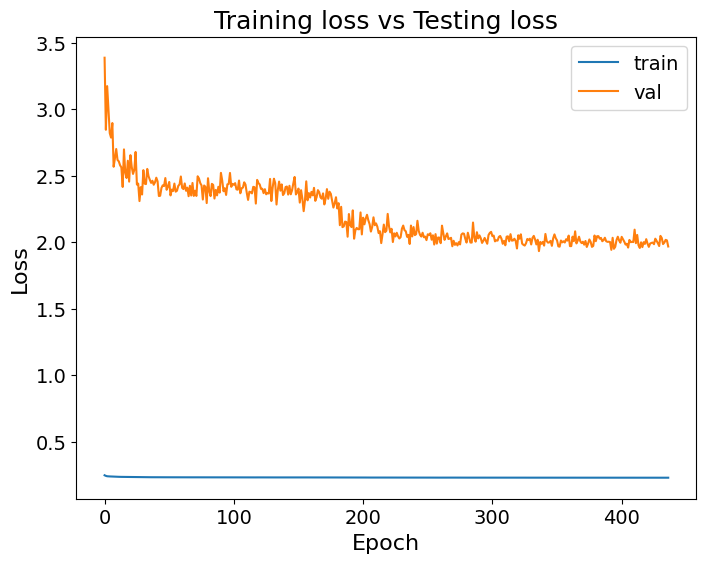

In [13]:
lr_schedule = keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=learning_rate, 
                                                          decay_steps=decay_steps,
                                                          decay_rate=decay_rate)

filda.compile(optimizer=Adam(learning_rate=lr_schedule),
             loss=[gate_loss, water_level_threshold], 
             loss_weights=[0.0, 3.0]
            )


es = EarlyStopping(monitor='val_loss', mode='min', verbose=2, patience=100)
mc = ModelCheckpoint('../saved_models/mlp_gtnp_1.h5'.format(n_hours, K),  # 2 best
                     monitor='val_ws_predictor_loss',
                     mode='min',
                     verbose=2, 
                     custom_objects={'gate_loss':gate_loss, 'water_level_threshold':water_level_threshold}, 
                     save_best_only=True)


history = filda.fit([train_X_mask, train_tws_reshape, train_adj_mat], [train_gate_pump_y, train_ws_y],
                   validation_data=([val_X_mask, val_tws_reshape, val_adj_mat], [val_gate_pump_y, val_ws_y]),
                   batch_size=BATCH, 
                   epochs=EPOCHS, 
                   verbose=2, 
                   callbacks=[es, mc],
                   shuffle=True,

                  )


plt.rcParams["figure.figsize"] = (8, 6)
plt.plot(history.history['ws_predictor_loss'], label='train')
plt.plot(history.history['val_ws_predictor_loss'], label='val')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Epoch', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend(fontsize=14)
plt.title("Training loss vs Testing loss", fontsize=18)
# plt.savefig('graph/rnn_loss.png', dpi=300)
plt.show()

### Performance

In [13]:
saved_model = load_model('../saved_models/mlp_gtnp_1.h5',
                         custom_objects={'gate_loss':gate_loss, 
                                         'water_level_threshold':water_level_threshold,
                                         'GCNConv': GCNConv
                                        }
                        )

In [14]:
start_time = time.perf_counter()


gate_pump_pred, ws_pred = saved_model.predict([test_X_mask, test_tws_reshape, test_adj_mat])

print(gate_pump_pred.shape)
print(ws_pred.shape)


end_time = time.perf_counter()
used_time = end_time - start_time
print(f"Usded time: {used_time} seconds")

2023-08-12 17:27:49.424010: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600


603/603 [==============================] - 5s 5ms/step
(19268, 24, 7)
(19268, 96)
Usded time: 6.132930879946798 seconds


#### ws pred, gate pred

In [16]:
ws_pred_gate_pred_inv = ws_scaler.inverse_transform(ws_pred)
ws_pred_gate_pred_inv = ws_pred_gate_pred_inv.reshape((-1, K, 4))
ws_pred_gate_pred_inv.shape

(19268, 24, 4)

#### ws true, gate true

In [17]:
ws_true_gate_true = test_ws_y
ws_true_gate_true_inv = ws_scaler.inverse_transform(ws_true_gate_true)
ws_true_gate_true_inv = ws_true_gate_true_inv.reshape((-1, K, 4))
ws_true_gate_true_inv.shape

(19268, 24, 4)

#### ws pred, gate true

In [18]:
ws_predictor = load_model('../saved_models/WaLeF_gtn_p.h5', custom_objects={'GCNConv': GCNConv})

ws_pred_gate_true = ws_predictor.predict([test_cov, test_tws_reshape, test_adj_mat])
ws_pred_gate_true_inv = ws_scaler.inverse_transform(ws_pred_gate_true)
ws_pred_gate_true_inv = ws_pred_gate_true_inv.reshape((-1, 24, 4))
ws_pred_gate_true_inv.shape

603/603 [==============================] - 2s 3ms/step


(19268, 24, 4)

### Upper threshould

In [19]:
upper_threshold = 3.5
t1 = 1

flood_threshold_t1(ws_true_gate_true_inv, t1, upper_threshold)
flood_threshold_t1(ws_pred_gate_true_inv, t1, upper_threshold)
flood_threshold_t1(ws_pred_gate_pred_inv, t1, upper_threshold)

S1, S25A, S25B, S26 time steps: 96, 96, 118, 117
S1, S25A, S25B, S26 areas: 14.82, 15.22, 18, 20.13
TOTAL time steps: 427; TOTAL areas: 68.61
--------------------------------------------------
S1, S25A, S25B, S26 time steps: 85, 85, 96, 108
S1, S25A, S25B, S26 areas: 11.5466, 12.1773, 13, 17.2181
TOTAL time steps: 374; TOTAL areas: 54.3063
--------------------------------------------------
S1, S25A, S25B, S26 time steps: 91, 109, 110, 125
S1, S25A, S25B, S26 areas: 13.3176, 16.6615, 17, 20.7371
TOTAL time steps: 435; TOTAL areas: 67.2843
--------------------------------------------------


In [20]:
flood_threshold_t1(ws_true_gate_true_inv[7640-23:7680-23], t1, upper_threshold)
flood_threshold_t1(ws_pred_gate_true_inv[7640-23:7680-23], t1, upper_threshold)
flood_threshold_t1(ws_pred_gate_pred_inv[7640-23:7680-23], t1, upper_threshold)

S1, S25A, S25B, S26 time steps: 6, 5, 6, 6
S1, S25A, S25B, S26 areas: 0.84, 0.72, 1, 1.0
TOTAL time steps: 23; TOTAL areas: 3.62
--------------------------------------------------
S1, S25A, S25B, S26 time steps: 6, 6, 5, 5
S1, S25A, S25B, S26 areas: 0.6148, 0.6425, 1, 0.8663
TOTAL time steps: 22; TOTAL areas: 3.0018
--------------------------------------------------
S1, S25A, S25B, S26 time steps: 6, 6, 5, 6
S1, S25A, S25B, S26 areas: 0.8667, 0.8531, 1, 1.2431
TOTAL time steps: 23; TOTAL areas: 4.1833
--------------------------------------------------


In [21]:
flood_threshold(ws_true_gate_true_inv, upper_threshold)
flood_threshold(ws_pred_gate_true_inv, upper_threshold)
flood_threshold(ws_pred_gate_pred_inv, upper_threshold)

time steps: 10248, areas: 1646.6399002075195
time steps: 12130, areas: 2088.0380942821503
time steps: 12729, areas: 2220.339081764221


### Lower threshold

In [22]:
lower_threshold = 0
t1 = 1

drought_threshold_t1(ws_true_gate_true_inv, t1, lower_threshold)
drought_threshold_t1(ws_pred_gate_true_inv, t1, lower_threshold)
drought_threshold_t1(ws_pred_gate_pred_inv, t1, lower_threshold)

S1, S25A, S25B, S26 time steps: 1346, 1341, 1229, 1250
S1, S25A, S25B, S26 areas: -385.8, -383.38, -345.08, -350.84:
TOTAL time steps: 5166; TOTAL areas: -1465.1
--------------------------------------------------
S1, S25A, S25B, S26 time steps: 1390, 1427, 1282, 1476
S1, S25A, S25B, S26 areas: -398.849, -392.0414, -350.2885, -429.5386:
TOTAL time steps: 5575; TOTAL areas: -1570.7176
--------------------------------------------------
S1, S25A, S25B, S26 time steps: 1071, 797, 678, 965
S1, S25A, S25B, S26 areas: -268.3594, -170.3829, -144.5184, -234.7964:
TOTAL time steps: 3511; TOTAL areas: -818.0571
--------------------------------------------------


In [23]:
drought_threshold_t1(ws_true_gate_true_inv[7640-23:7680-23], t1, lower_threshold)
drought_threshold_t1(ws_pred_gate_true_inv[7640-23:7680-23], t1, lower_threshold)
drought_threshold_t1(ws_pred_gate_pred_inv[7640-23:7680-23], t1, lower_threshold)

S1, S25A, S25B, S26 time steps: 0, 0, 0, 0
S1, S25A, S25B, S26 areas: 0, 0, 0, 0:
TOTAL time steps: 0; TOTAL areas: 0
--------------------------------------------------
S1, S25A, S25B, S26 time steps: 0, 0, 0, 0
S1, S25A, S25B, S26 areas: 0, 0, 0, 0:
TOTAL time steps: 0; TOTAL areas: 0
--------------------------------------------------
S1, S25A, S25B, S26 time steps: 0, 0, 0, 0
S1, S25A, S25B, S26 areas: 0, 0, 0, 0:
TOTAL time steps: 0; TOTAL areas: 0
--------------------------------------------------


In [24]:
drought_threshold(ws_true_gate_true_inv, lower_threshold)
drought_threshold(ws_pred_gate_true_inv, lower_threshold)
drought_threshold(ws_pred_gate_pred_inv, lower_threshold)

time steps: 124148, areas: 35182.6098122485
time steps: 127126, areas: 34960.07284716559
time steps: 52148, areas: 11182.73020836878
